In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from abc import abstractmethod, ABC
from functools import partial
from typing import List

from jax import jit, vmap, grad, device_get
from jax import config
from matplotlib.colors import LogNorm
from tqdm import tqdm
import jaxquantum as jqt
import jax.numpy as jnp
# import scqubits as scq
# from scqubits.utils.spectrum_utils import matrix_element as mel
import qutip as qt
import matplotlib.pyplot as plt 
import numpy as np

from scipy import constants

from copy import deepcopy

config.update("jax_enable_x64", True)
jnp.set_printoptions(linewidth=jnp.inf)

import qcsys as qs
import time

# ---

from bosonic import Qubit, GKPQubit, execute, BosonicRegister, BosonicCircuit
import numpy as np
import matplotlib.pyplot as plt

import jaxquantum as jqt
import jax.numpy as jnp

/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [3]:
# This cell uses `bosonic_custom` a module of gates and simulations specific to the MIT EQuS Bosonic QEC team. 
# As such, this code will not run for everyone, but can still be used as an example. 

import sys
sys.path.append("../../../bosonic-sims/")
sys.path.append("/Users/phionx/Github/qc/EQuS/bosonic/device_sims/qcsys-bosonic-sims/tutorials/1-common-infra")

from bosonic_custom import NumSplitCDGate
from helpers import *

In [5]:
@jit
def calculate_metric(E_Lq):
    # specific_params = gen_params_resonator_fluxonium()

    specific_params = get_full_params_dispersive_design()
    specific_params["Fluxonium__E_L"] = E_Lq
    specific_params["phi_ext"] = 0.43
    specific_results = run_analysis_with_params(specific_params, get_metrics_normal_resonator_fluxonium, metrics_mask=simple_metrics_mask)
    
    chi = specific_results["metrics"]["χ_aq"][0]
    Kerr = (specific_results["metrics"]["K_e"][0] + specific_results["metrics"]["K_g"][0])/2

    # parameters & constants
    π = jnp.pi ; 
    χ = 2*π * 2 ; 
    K = 2*π * Kerr
    beta = jnp.sqrt(2)*2*(2.5 + 2j)
    N = 50

    # set up operators
    a = jqt.destroy(N)
    a_dag = jqt.dag(a)
    I_q = jnp.eye(2)
    I_a = jnp.eye(N)
    aq = jnp.kron(a, I_q)
    aq_dag = jqt.dag(aq)

    # base hamiltonian
    H0 = jnp.kron(χ*a_dag@a, jqt.sigmaz()) + (K/2)*aq_dag @ aq_dag @ aq @ aq
    final_time = 2*π/χ
    ts = jnp.linspace(0.0, final_time, 251)

    # set up new circuit
    breg = BosonicRegister([GKPQubit(params={"N":N}),Qubit()]) # create register
    bcirc = BosonicCircuit(breg) # create circuit
    bcirc.add(NumSplitCDGate, (0,1),{"beta": beta, "chi": χ}, ts) # add gate
    results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[]) # run circuit simulation
    results.calc_expect(aq, "aq")
    expt = results[0]["aq"]
    final_g = expt[-1]


    breg = BosonicRegister([GKPQubit(params={"N":N}),Qubit()]) # create register
    bcirc = BosonicCircuit(breg) # create circuit
    p0 = bcirc.gen_default_initial_state()
    p0 = jqt.tensor(jqt.identity(N), jqt.sigmax()) @ p0
    bcirc.add(NumSplitCDGate, (0,1),{"beta": beta, "chi": χ}, ts) # add gate
    results = execute(bcirc, "hamiltonian_jax", H0=H0, p0=p0, c_ops=[]) # run circuit simulation
    results.calc_expect(aq, "aq")
    final_e = expt[-1]

    distance = jnp.abs(final_g - final_e)

    return distance/final_time

In [6]:
g_cd_rate = calculate_metric(0.3)
g_cd_rate

TypeError: jnp.linalg.eigh requires ndarray or scalar arguments, got <class 'jaxquantum.core.qarray.Qarray'> at position 0.

In [58]:
expt[-1]

Array(2.39685162+1.90243472j, dtype=complex128)

In [40]:
jqt.plot_wigner(final_state, jnp.linspace(-5,5,100))

TypeError: must be real number, not dict

In [4]:
# parameters & constants
π = jnp.pi ; χ = 2*π * 2 ; K = 2*π * 0
beta = jnp.sqrt(2)*2*(2.5 + 2j)
N = 50

# set up operators
a = jqt.destroy(N)
a_dag = jqt.dag(a)
I_q = jnp.eye(2)
I_a = jnp.eye(N)
aq = jnp.kron(a, I_q)
aq_dag = jqt.dag(aq)

# base hamiltonian
H0 = jnp.kron(χ*a_dag@a, jqt.sigmaz()) + (K/2)*aq_dag @ aq_dag @ aq @ aq
ts = jnp.linspace(0.0, 2*π/χ, 251)

# set up new circuit
breg = BosonicRegister([GKPQubit(params={"N":N}),Qubit()]) # create register
bcirc = BosonicCircuit(breg) # create circuit
bcirc.add(NumSplitCDGate, (0,1),{"beta": beta, "chi": χ}, ts) # add gate
results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[]) # run circuit simulation
results.calc_expect(aq, "aq")
%timeit results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[])

504 ms ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


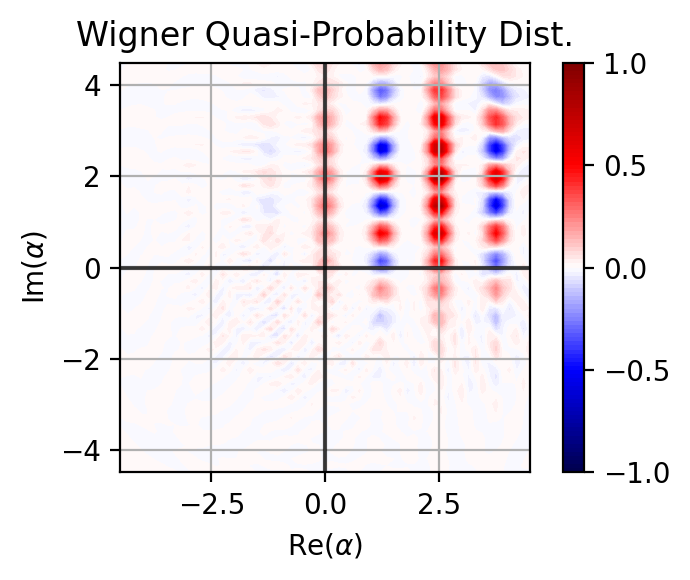

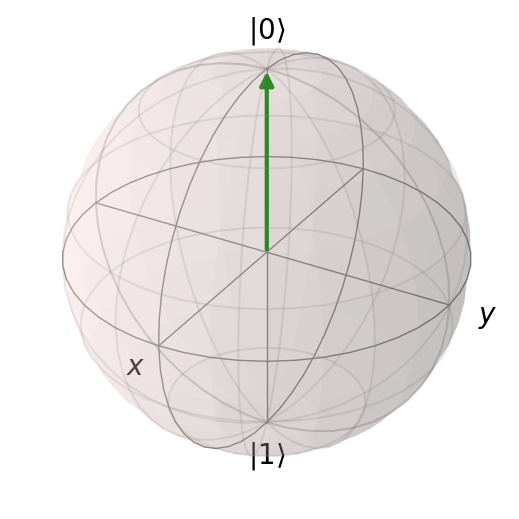

<Figure size 640x480 with 0 Axes>

In [5]:
results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[])
results.plot(bcirc, 0)
results.plot(bcirc, 1)

In [6]:
results.calc_expect(aq, "aq")

In [7]:
def plot_trajectory(ts, expectation):
    fig, axs = plt.subplots(1,2, dpi=200, figsize=(8,3))
    axs[0].plot(np.real(expectation), np.imag(expectation))
    axs[0].set_xlabel(r"$\langle \hat{q}\rangle$")
    axs[0].set_ylabel(r"$\langle \hat{p}\rangle$")
    
    axs[1].plot(ts, np.real(expectation), label=r"$\langle \hat{q}\rangle$")
    axs[1].plot(ts, np.imag(expectation), label=r"$\langle \hat{p}\rangle$")
    axs[1].set_ylabel(r'Expectation of quadratures')
    axs[1].set_xlabel('Time')
    axs[1].legend()

    fig.tight_layout()
    plt.show()

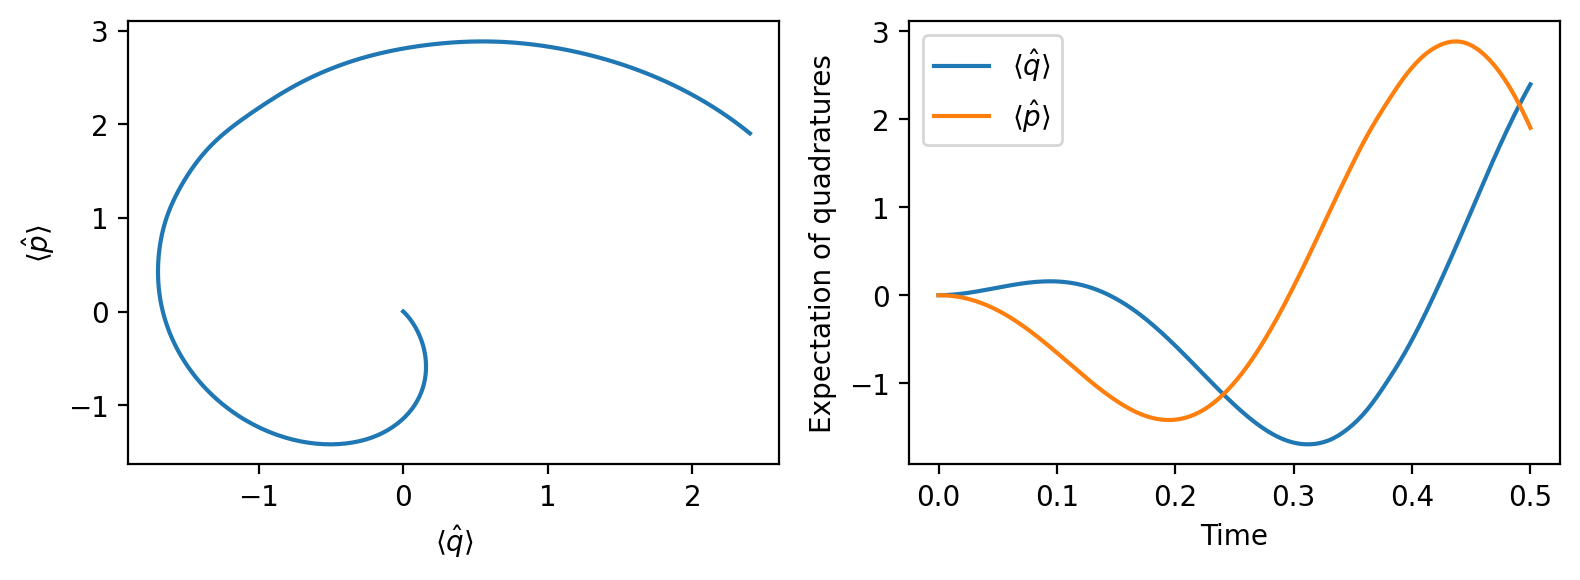

1.9024347204388714


In [8]:
expt = results[0]["aq"]
plot_trajectory(ts, expt)
print(np.imag(expt[-1]))